## 1. Import Required Libraries

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import qr
from scipy.stats import norm, rayleigh
import itertools


## 2. Define Simulation Parameters

In [20]:
# System parameters
nt = 4  # Transmit antennas
nr = 2  # Receive antennas
mod_order = 4  # QPSK (4 symbols)
snr_db_range = np.arange(0, 25, 2)  # SNR in dB

# Constellation Mapping for QPSK
def qpsk_modulate(bits):
    symbols = (2*bits[:, 0] - 1) + 1j * (2*bits[:, 1] - 1)
    return symbols / np.sqrt(2)  # Normalize power


## 3. Generate DSTTD Encoding Matrix

In [22]:
def dsttd_encode(symbols):
    """ Encode 4 QPSK symbols into a 4x2 DSTTD matrix """
    S = np.zeros((nt, 2), dtype=complex)
    S[0, :] = [symbols[0], symbols[1]]
    S[1, :] = [-symbols[1].conj(), symbols[0].conj()]
    S[2, :] = [symbols[2], symbols[3]]
    S[3, :] = [-symbols[3].conj(), symbols[2].conj()]
    return S


## 4. Simulate Rayleigh Channel and Add Noise

In [24]:
def simulate_channel(nt, nr):
    """ Simulate a Rayleigh fading channel matrix H (nr x nt) """
    return (rayleigh.rvs(size=(nr, nt)) + 1j * rayleigh.rvs(size=(nr, nt))) / np.sqrt(2)

def add_awgn(signal, snr_db):
    """ Add AWGN noise based on SNR """
    snr_linear = 10 ** (snr_db / 10)
    noise_power = np.mean(np.abs(signal) ** 2) / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise


## 5. Implement QR Decomposition & ML Detection

In [26]:
def ml_decoder(Y, H, constellation):
    """ Brute-force ML detector: finds the closest 4-symbol vector """
    min_dist = np.inf
    best_symbols = None
    
    # Generate all possible 4-symbol combinations from the constellation
    for s in itertools.product(constellation, repeat=4):
        s_vec = np.array(s)
        S_test = dsttd_encode(s_vec)
        error = np.linalg.norm(Y - H @ S_test)
        if error < min_dist:
            min_dist = error
            best_symbols = s_vec
    return best_symbols


## 6. Run the Simulation and Compute BER

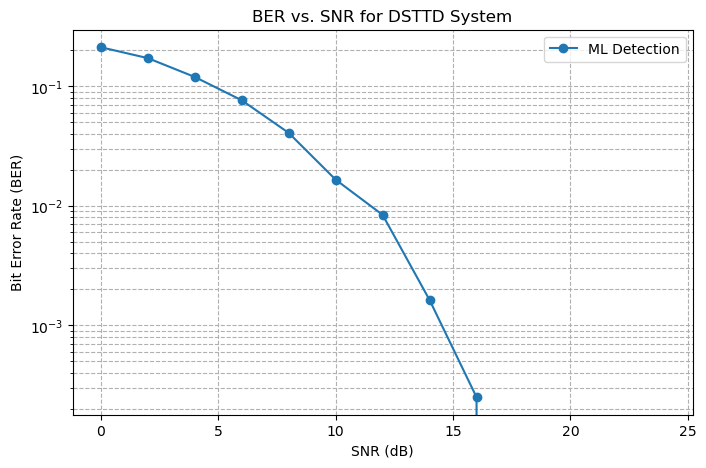

In [28]:
ber_results = []

for snr_db in snr_db_range:
    errors = 0
    total_bits = 0

    for _ in range(1000):  # Run 1000 symbols
        bits = np.random.randint(0, 2, (4, 2))
        symbols = qpsk_modulate(bits)
        S = dsttd_encode(symbols)

        H = simulate_channel(nt, nr)
        Y = add_awgn(H @ S, snr_db)

        decoded_symbols = ml_decoder(Y, H, np.array([-1-1j, -1+1j, 1-1j, 1+1j]) / np.sqrt(2))
        decoded_bits = np.column_stack([(decoded_symbols.real > 0).astype(int), (decoded_symbols.imag > 0).astype(int)])

        errors += np.sum(bits != decoded_bits)
        total_bits += bits.size

    ber_results.append(errors / total_bits)

# Plot BER Curve
plt.figure(figsize=(8, 5))
plt.semilogy(snr_db_range, ber_results, marker='o', linestyle='-', label="ML Detection")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("BER vs. SNR for DSTTD System")
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()


# 📌 Visualization

## Channel Gain Heatmap


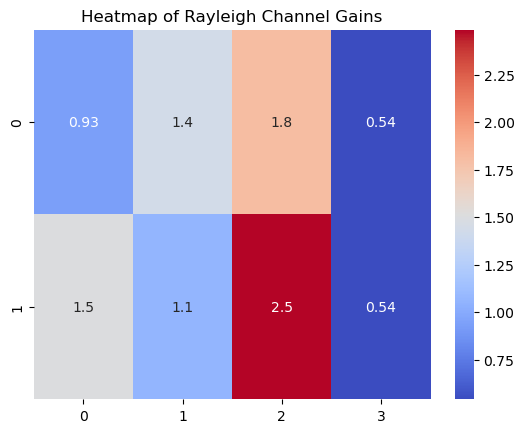

In [33]:
H = simulate_channel(nt, nr)
sns.heatmap(np.abs(H), annot=True, cmap="coolwarm")
plt.title("Heatmap of Rayleigh Channel Gains")
plt.show()


## Constellation Diagram (Before & After Decoding)

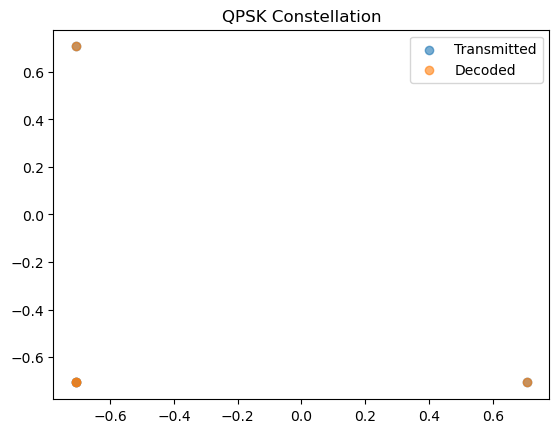

In [36]:
plt.scatter(symbols.real, symbols.imag, label="Transmitted", alpha=0.6)
plt.scatter(decoded_symbols.real, decoded_symbols.imag, label="Decoded", alpha=0.6)
plt.title("QPSK Constellation")
plt.legend()
plt.show()
